In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error

import time
import tqdm
import torch

from torch.utils.data import DataLoader

%run models/models.ipynb

plt.style.use('dark_background')

### Datasets

In [2]:
OPTION_PROBABILITIES_PATH = 'simulated_prices/complete_option_probabilities_100M.csv'
REVERSED_OPTION_PROBABILITIES_PATH = 'simulated_prices/reversed_option_probabilities_100M.csv'

class ChunkDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path, binary=True, scheme=None, 
                 chunk_size=10000, dataset_size=101 * 101 * 10000):
        
        # Scheme
        
        default_scheme = {'target_column': 'probability',
                          'field_columns':
                              {'initial_stock_price': ('>f', 32),
                               'volatility': ('>i1', 8),
                               'option_price': ('>f', 32)}}                          
        
        scheme = default_scheme if scheme is None else scheme

        target_column = scheme['target_column']
        fields_scheme = scheme['field_columns']
        
        
        # Data

        chunks_count = dataset_size // chunk_size        
              
        dataset_iterator = pd.read_csv(dataset_path, iterator=True, chunksize=chunk_size)
        
        chunk_tracker = tqdm.tqdm(range(chunks_count),
                                  desc=f"Loading",
                                  ncols=110,
                                  unit='chunk',
                                  total=chunks_count)                          
        # Loading
        
        if binary:            
            fields_count = sum(bit_count for encoding_format, bit_count in fields_scheme.values())
            fields_dtype = 'int8'
        else:            
            fields_count = len(scheme)
            fields_dtype = float
        
        self.fields = np.zeros(shape=(dataset_size, fields_count), dtype=fields_dtype)
        self.targets = np.zeros(shape=dataset_size)
        
        row_offset = 0

        for chunk_index in chunk_tracker:
            
            chunk = next(dataset_iterator)

            column_offset = 0

            for column_name, (encoding_format, column_size) in fields_scheme.items():
                
                if column_name == 'volatility':                    
                    chunk[column_name] = 100 * chunk[column_name]

                if binary:
                    column = self.encode_to_bits(chunk[column_name], 
                                                 dtype=encoding_format, 
                                                 bits_count=column_size)                        
                else:                        
                    column = chunk[column_name].to_numpy().reshape(-1, 1)                        
                    column_size = 1                        

                self.fields[row_offset : row_offset + chunk_size, 
                            column_offset : column_offset + column_size] = column

                column_offset += column_size
                
            self.targets[row_offset : row_offset + chunk_size] = chunk[target_column]

            row_offset += chunk_size
       
        # self.field_dimensions = np.max(self.fields, axis=0).astype(int) + 1
        
        self.field_dimensions = 2 * np.ones(self.fields.shape[1], dtype=int)
        
        # print("fields.shape:", self.fields.shape)
        # print("targets.shape:", self.targets.shape) 
        # print("field_dimensions:", self.field_dimensions)     
        
        
    def __len__(self):
        
        return self.fields.shape[0]
    

    def __getitem__(self, index):
        
        fields = self.fields[index]
        target = self.targets[index]
        
        # print("index:", index)
        # print("fields:", fields)       
        # print("target:", target)
        
        return fields, target
    

    def encode_to_bits(self, inputs, dtype='>f', bits_count=32):
    
        number_bytes = np.array([inputs], dtype=dtype)

        integer_view = number_bytes.view('uint8')

        bits_vector = np.unpackbits(integer_view)
        
        bits = bits_vector.reshape(-1, bits_count)

        return bits

### Splitter

In [3]:
class SequentialValueSampler(torch.utils.data.Sampler):

    def __init__(self, values):
        self.values = values

    def __iter__(self):
        return iter(self.values)

    def __len__(self):
        return len(self.values)


class Splitter:
    
    def __init__(self, dataset, shuffle=True, 
                 train_rate=0.8, valid_rate=0.1, 
                 batch_size=2048, dataloader_workers_count=8):
                    
        dataset_length = len(dataset)

        train_length = int(dataset_length * train_rate)
        valid_length = int(dataset_length * valid_rate)

        test_length = dataset_length - train_length - valid_length
        
        ###

        dataset_indices = np.arange(dataset_length, dtype=int)
        
        print("dataset_indices.shape:", dataset_indices.shape)  
        
        print("dataset_indices:", dataset_indices, dataset_indices.dtype) 
        
        if shuffle:        
            np.random.shuffle(dataset_indices)
        
        print("dataset_indices:", dataset_indices, dataset_indices.dtype)  
        
        index_ranges = np.split(dataset_indices, (train_length,
                                                  train_length + valid_length))
        
        train_indices, valid_indices, test_indices = index_ranges
        
        print(train_indices, valid_indices, test_indices)
        print(train_indices.shape[0], valid_indices.shape[0], test_indices.shape[0],
              train_indices.shape[0] + valid_indices.shape[0] + test_indices.shape[0])
        
            
        train_sampler, valid_sampler, test_sampler = map(SequentialValueSampler, index_ranges)

        self.train_data_loader = DataLoader(dataset,
                                            batch_size=batch_size,
                                            sampler=train_sampler,
                                            num_workers=dataloader_workers_count)
        
        self.valid_data_loader = DataLoader(dataset,                                  
                                            batch_size=batch_size,
                                            sampler=valid_sampler,
                                            num_workers=dataloader_workers_count)
        
        self.test_data_loader = DataLoader(dataset,
                                           batch_size=batch_size,
                                           sampler=test_sampler,
                                           num_workers=dataloader_workers_count)   

### Trainer

In [4]:
class Trainer:

    def __init__(self, model, criterion, metric, optimizer, splitter, device='cpu',
                 epochs_logging_interval=1):
        
        self.device = torch.device(device)
        
        self.model = model.to(device)
        self.criterion = criterion
        self.metric = metric
        self.optimizer = optimizer
        self.splitter = splitter
        
        self.epochs_logging_interval = epochs_logging_interval
        
        self.train_data_loader = self.splitter.train_data_loader
        self.valid_data_loader = self.splitter.valid_data_loader
        self.test_data_loader = self.splitter.test_data_loader
        
        self.scores = []
        self.losses_per_epoch = []
        
        # TODO: EarlyStopper
    
    
    def fit(self, epochs=10):
    
        for epoch in range(epochs):
            
            epoch_start_time = time.time()
            
            train_batch_tracker = tqdm.tqdm(
                self.train_data_loader,
                desc=f"Epoch: {epoch + 1}/{epochs}",
                unit=' batches',
                ncols=110,
                mininterval=1,
            )            
            
            self.train(train_batch_tracker)
            
            score, _ = self.test(self.valid_data_loader)
            
            self.scores.append(score)
            
            epoch_duration = time.time() - epoch_start_time
            
            print(f"Validation {self.metric.__name__}: {score:.05f}, "
                  f"Duration: {epoch_duration:.02f} seconds") 
            
        total_score, total_predictions = self.test(self.test_data_loader)
        
        self.predictions = total_predictions
        
        print(f"\nTotal - Test {metric.__name__}: {total_score:.010f}")
    
    
    def train(self, train_batch_tracker):

        self.model.train()

        total_loss = 0
        
        losses = []

        for batch, (fields, target) in enumerate(train_batch_tracker):
            
            predictions = self.model(fields.int())
            
            loss = self.criterion(predictions, target.float())

            self.model.zero_grad()

            loss.backward()

            self.optimizer.step()

            total_loss += loss.item()

            if not (batch + 1) % self.epochs_logging_interval:

                loss = total_loss / self.epochs_logging_interval

                train_batch_tracker.set_postfix(loss=loss)
                
                losses.append(loss)

                total_loss = 0
                
        self.losses_per_epoch.append(losses)
                
                
    def test(self, data_loader):
        
        self.model.eval()
    
        targets = []
        predictions = []

        with torch.no_grad():

            for fields, target in data_loader:

                prediction = self.model(fields.int())

                targets.extend(target.tolist())
                predictions.extend(prediction.tolist())

        score = self.metric(targets, predictions)
        
        return score, predictions

### 5) Probabilities - 100K Dataset

In [10]:
# Load Data

OPTION_PROBABILITIES_PATH = 'simulated_prices/option_probabilities_100K.csv'

dataset = ChunkDataset(
    OPTION_PROBABILITIES_PATH, 
    chunk_size=1000, 
    dataset_size=11 * 11 * 1000
    # dataset_size=10000,
)

field_dimensions = dataset.field_dimensions

print("dataset.fields.shape:", dataset.fields.shape)
print("dataset.targets.shape:", dataset.targets.shape) 
print("dataset.field_dimensions:", dataset.field_dimensions, dataset.field_dimensions.sum())    

Loading: 100%|██████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 592.90chunk/s]

dataset.fields.shape: (121000, 72)
dataset.targets.shape: (121000,)
dataset.field_dimensions: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 144


In [11]:
splitter = Splitter(dataset, batch_size=100, dataloader_workers_count=8)

dataset_indices.shape: (121000,)
dataset_indices: [     0      1      2 ... 120997 120998 120999] int64
dataset_indices: [ 10808  48703  72016 ...  62103  98769 104469] int64
[10808 48703 72016 ... 79808 45920 79543] [48887 49979 22991 ... 32766 99910 16131] [ 26151  75856  98570 ...  62103  98769 104469]
96800 12100 12100 121000


In [12]:
# Model

LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-6

embedding_dimension = 16

%run models/models.ipynb

model = CustomFactorizationMachine(field_dimensions, embedding_dimension=embedding_dimension)

criterion = torch.nn.MSELoss()

metric = mean_squared_error

optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=LEARNING_RATE, 
                             weight_decay=WEIGHT_DECAY)

In [13]:
trainer = Trainer(model=model,
                  criterion=criterion,
                  metric=metric,
                  optimizer=optimizer,
                  splitter=splitter)

In [14]:
trainer.fit(epochs=10)

Epoch: 1/10: 100%|███████████████████████████████████████| 968/968 [00:05<00:00, 181.63 batches/s, loss=0.265]


Validation mean_squared_error: 0.22092, Duration: 5.71 seconds


Epoch: 2/10: 100%|███████████████████████████████████████| 968/968 [00:05<00:00, 181.88 batches/s, loss=0.126]


Validation mean_squared_error: 0.11486, Duration: 5.68 seconds


Epoch: 3/10: 100%|██████████████████████████████████████| 968/968 [00:05<00:00, 181.20 batches/s, loss=0.0543]


Validation mean_squared_error: 0.03890, Duration: 5.72 seconds


Epoch: 4/10: 100%|██████████████████████████████████████| 968/968 [00:05<00:00, 182.81 batches/s, loss=0.0255]


Validation mean_squared_error: 0.01657, Duration: 5.66 seconds


Epoch: 5/10: 100%|██████████████████████████████████████| 968/968 [00:05<00:00, 182.03 batches/s, loss=0.0149]


Validation mean_squared_error: 0.02594, Duration: 5.67 seconds


Epoch: 6/10: 100%|█████████████████████████████████████| 968/968 [00:05<00:00, 185.73 batches/s, loss=0.00955]


Validation mean_squared_error: 0.00724, Duration: 5.58 seconds


Epoch: 7/10: 100%|█████████████████████████████████████| 968/968 [00:05<00:00, 189.41 batches/s, loss=0.00528]


Validation mean_squared_error: 0.00362, Duration: 5.47 seconds


Epoch: 8/10: 100%|█████████████████████████████████████| 968/968 [00:05<00:00, 181.72 batches/s, loss=0.00394]


Validation mean_squared_error: 0.00286, Duration: 5.69 seconds


Epoch: 9/10: 100%|█████████████████████████████████████| 968/968 [00:05<00:00, 179.38 batches/s, loss=0.00287]


Validation mean_squared_error: 0.00218, Duration: 5.80 seconds


Epoch: 10/10: 100%|████████████████████████████████████| 968/968 [00:05<00:00, 181.12 batches/s, loss=0.00751]


Validation mean_squared_error: 0.01089, Duration: 5.71 seconds

Total - Test mean_squared_error: 0.0105799104


In [ ]:
# trainer.scores[:]

In [ ]:
plt.plot(trainer.scores[:], label="MSE")
    
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend();

In [ ]:
MODEL_PATH = 'saved_models/factorization_machine_100K_16_embeddings.pt'

torch.save(model.state_dict(), MODEL_PATH)

### Predict - 100K Dataset

In [56]:
def encode_to_bits(inputs, dtype='>f', bits_count=32):

    number_bytes = np.array([inputs], dtype=dtype)

    integer_view = number_bytes.view('uint8')

    bits_vector = np.unpackbits(integer_view)

    bits = bits_vector.reshape(-1, bits_count)

    return bits


def decode_from_bits(bits, dtype='>f', bitorder='big'):
    
    bits_vector = bits.reshape(-1)
    
    integer_view = np.packbits(bits_vector, bitorder=bitorder)

    output = integer_view.view(dtype)
    
    return output

In [57]:
for fields_batch, target_batch in splitter.test_data_loader:
   
    for fields, target in zip(fields_batch[:10], target_batch[:10]):
        
        intial_option_price_bits = fields[:32].numpy()
        volatility_bits = fields[32:32 + 8].numpy()

        intial_option_price = decode_from_bits(intial_option_price_bits)
        volatility = decode_from_bits(volatility_bits, dtype='i1')

        print(intial_option_price_bits, volatility_bits, intial_option_price, volatility)
        
    break

[0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 1 0 1 0 0 0] [300.] [40]
[0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 1 0 1 0 0] [500.] [20]
[0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 1 1 1 1 0] [300.] [30]
[0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 1 0 1 0 0] [600.] [20]
[0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 1 1 1 1 0] [400.] [30]
[0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 1 0 1 0] [400.] [10]
[0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 1 0 1 0 0] [100.] [20]
[0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 0 1 0 0 0 0] [700.] [80]
[0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 0 0 0 1 1 0] [700.] [70]
[0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 0 0 0 1 1 0] [600.] [70]


In [60]:
model.eval()
    
targets = []
predictions = []
fields_list = []

with torch.no_grad():

    for fields, target in trainer.splitter.test_data_loader:
        
        prediction = model(fields.int())

        targets.extend(target.tolist())
        predictions.extend(prediction.tolist())
        fields_list.extend(fields)
        
        break
        
for fields, target, prediction in list(zip(fields_list, targets, predictions))[:10]:

    intial_stock_price_bits = fields[:32]
    volatility_bits = fields[32 : 32 + 8]
    option_price_bits = fields[32 + 8 : 32 + 8 + 32]
    
    intial_stock_price = decode_from_bits(intial_stock_price_bits)
    volatility = decode_from_bits(volatility_bits, dtype='i1')
    option_price = decode_from_bits(option_price_bits)
    
    print(intial_stock_price, volatility, option_price, target, prediction, target - prediction)

[300.] [40] [129.86308] 9e-05 4.39123981621492e-09 8.999560876018379e-05
[500.] [20] [439.8291] 9e-05 5.0809403546736576e-06 8.491905964532635e-05
[300.] [30] [172.93678] 9e-05 4.221961660277884e-07 8.957780383397222e-05
[600.] [20] [415.19144] 8e-05 1.0161644325989982e-07 7.98983835567401e-05
[400.] [30] [166.07182] 8e-05 4.852965945767451e-11 7.999995147034055e-05
[400.] [10] [252.02824] 7e-05 3.70824260187419e-08 6.996291757398125e-05
[100.] [20] [-11.100469] 7e-05 3.004558823960224e-10 6.99996995441176e-05
[700.] [80] [321.24167] 0.00023 1.0214783463524668e-09 0.00022999897852165365
[700.] [70] [271.08585] 0.00019 3.765796563470758e-09 0.00018999623420343654
[600.] [70] [182.81741] 0.00017 8.574980725484238e-09 0.00016999142501927453


### 4) Probabilities - 100M Dataset

In [5]:
# Load Data

dataset = ChunkDataset(
    # REVERSED_OPTION_PROBABILITIES_PATH,
    OPTION_PROBABILITIES_PATH, 
    # dataset_size=1000000,
)

field_dimensions = dataset.field_dimensions

print("dataset.fields.shape:", dataset.fields.shape)
print("dataset.targets.shape:", dataset.targets.shape) 
print("dataset.field_dimensions:", dataset.field_dimensions, dataset.field_dimensions.sum())    

Loading: 100%|██████████████████████████████████████████████████████| 10201/10201 [01:02<00:00, 163.38chunk/s]

dataset.fields.shape: (102010000, 72)
dataset.targets.shape: (102010000,)
dataset.field_dimensions: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 144


In [6]:
splitter = Splitter(dataset, batch_size=1000, dataloader_workers_count=8)

dataset_indices.shape: (102010000,)
dataset_indices: [        0         1         2 ... 102009997 102009998 102009999] int64
dataset_indices: [81260510 72987896 91541084 ... 98454314 48837090 71213999] int64
[81260510 72987896 91541084 ... 80462463 17308774 69807394] [76727132  7648110 25702263 ... 90223167 89350706 41100475] [ 46547273  94003251 101634449 ...  98454314  48837090  71213999]
81608000 10201000 10201000 102010000


In [7]:
# Model

LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-6

embedding_dimension = 144

%run models/models.ipynb

model = CustomFactorizationMachine(field_dimensions, embedding_dimension=embedding_dimension)

criterion = torch.nn.MSELoss()

metric = mean_squared_error

optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=LEARNING_RATE, 
                             weight_decay=WEIGHT_DECAY)

In [8]:
trainer = Trainer(model=model,
                  criterion=criterion,
                  metric=metric,
                  optimizer=optimizer,
                  splitter=splitter)

In [9]:
trainer.fit(epochs=1)

Epoch: 1/1: 100%|███████████████████████████████| 81608/81608 [14:53:06<00:00,  1.52 batches/s, loss=0.000154]


Validation mean_squared_error: 0.00020, Duration: 53754.09 seconds

Total - Test mean_squared_error: 0.00020


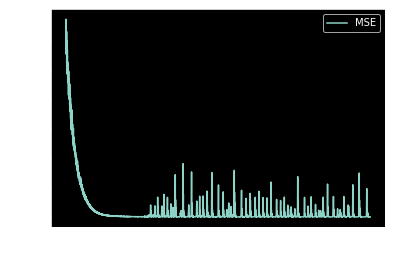

In [38]:
plt.plot(trainer.losses_per_epoch[0][100:10000], label="MSE")
    
plt.xlabel("Batch")
plt.ylabel("Mean Square Error")
plt.legend();

In [ ]:
# 10 initial stock prices, 10 volatilities, 1000 most probable bins -> 1M dataset

# number of samples -> 1M

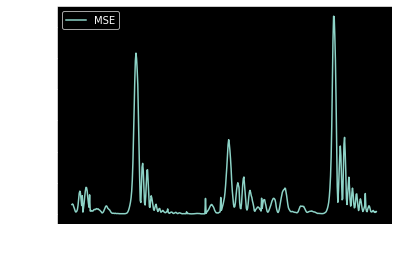

In [30]:
plt.plot(trainer.losses_per_epoch[0][-500:], label="MSE")
    
plt.xlabel("Batch")
plt.ylabel("Mean Square Error")
plt.legend();

In [12]:
# model.state_dict()

In [13]:
MODEL_PATH = 'saved_models/factorization_machine_100M_144_embeddings.pt'

torch.save(model.state_dict(), MODEL_PATH)

### Predict - 100M Dataset

In [ ]:
# Load Data

dataset = ChunkDataset(
    REVERSED_OPTION_PROBABILITIES_PATH,
    # OPTION_PROBABILITIES_PATH, 
    dataset_size=1000000,
)

field_dimensions = dataset.field_dimensions

print("dataset.fields.shape:", dataset.fields.shape)
print("dataset.targets.shape:", dataset.targets.shape) 
print("dataset.field_dimensions:", dataset.field_dimensions, dataset.field_dimensions.sum())    

Loading: 100%|██████████████████████████████████████████████████████| 10201/10201 [00:55<00:00, 185.36chunk/s]

dataset.fields.shape: (102010000, 72)
dataset.targets.shape: (102010000,)
dataset.field_dimensions: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 144


In [ ]:
splitter = Splitter(dataset, batch_size=1000, dataloader_workers_count=8)

dataset_indices.shape: (102010000,)
dataset_indices: [        0         1         2 ... 102009997 102009998 102009999] int64
dataset_indices: [39404751 33074587 28512073 ... 29626845 39104549 12665155] int64
[39404751 33074587 28512073 ... 65287990 51979360 23205434] [ 4091019 26345064 58833450 ... 89453440 14510084 59233113] [22741452 16869266 38587347 ... 29626845 39104549 12665155]
81608000 10201000 10201000 102010000


In [ ]:
# MODEL_PATH = 'saved_models/factorization_machine_100M.pt'

# loaded_model = CustomFactorizationMachine(field_dimensions, embedding_dimension=embedding_dimension)

# state_dict = torch.load(MODEL_PATH)
# loaded_model.load_state_dict(state_dict)
# loaded_model.eval()

In [14]:
def encode_to_bits(inputs, dtype='>f', bits_count=32):

    number_bytes = np.array([inputs], dtype=dtype)

    integer_view = number_bytes.view('uint8')

    bits_vector = np.unpackbits(integer_view)

    bits = bits_vector.reshape(-1, bits_count)

    return bits


def decode_from_bits(bits, dtype='>f', bitorder='big'):
    
    bits_vector = bits.reshape(-1)
    
    integer_view = np.packbits(bits_vector, bitorder=bitorder)

    output = integer_view.view(dtype)
    
    return output

In [15]:
for fields_batch, target_batch in splitter.test_data_loader:
   
    for fields, target in zip(fields_batch[:10], target_batch[:10]):
        
        intial_option_price_bits = fields[:32].numpy()
        volatility_bits = fields[32:32 + 8].numpy()

        intial_option_price = decode_from_bits(intial_option_price_bits)
        volatility = decode_from_bits(volatility_bits, dtype='i1')

        print(intial_option_price_bits, volatility_bits, intial_option_price, volatility)
        
    break

[0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 1 0 0 0] [4600.] [8]
[0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 1 1 1] [9300.] [7]
[0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 1 1 1 1 1 1] [10000.] [63]
[0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 0 0 0 0 1 0] [2700.] [66]
[0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 0 0 1 1 0 0] [4200.] [76]
[0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 0 0 1 0 0 0] [2100.] [72]
[0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 0 1 0 1 0 1] [1400.] [85]
[0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 1 0 1 0 1 0] [1500.] [42]
[0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 1 0 1 0 1 1] [5700.] [43]
[0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0] [6200.] [0]


In [17]:
model.eval()
    
targets = []
predictions = []
fields_list = []

with torch.no_grad():

    for fields, target in trainer.splitter.test_data_loader:
        
        prediction = model(fields.int())

        targets.extend(target.tolist())
        predictions.extend(prediction.tolist())
        fields_list.extend(fields)
        
        break
        
for fields, target, prediction in list(zip(fields_list, targets, predictions))[:10]:

    intial_stock_price_bits = fields[:32]
    volatility_bits = fields[32 : 32 + 8]
    option_price_bits = fields[32 + 8 : 32 + 8 + 32]
    
    intial_stock_price = decode_from_bits(intial_stock_price_bits)
    volatility = decode_from_bits(volatility_bits, dtype='i1')
    option_price = decode_from_bits(option_price_bits)
    
    print(intial_stock_price, volatility, option_price, target, prediction)

[4600.] [8] [4124.875] 0.0002 -0.009663581848144531
[9300.] [7] [7468.6055] 0.0004 -0.01102834939956665
[10000.] [63] [31947.064] 0.0 -0.026633262634277344
[2700.] [66] [145.7075] 0.001 0.01563405990600586
[4200.] [76] [13736.384] 0.0001 -0.019412517547607422
[2100.] [72] [10532.518] 0.0 -0.00978231430053711
[1400.] [85] [22192.334] 0.0 -0.01628589630126953
[1500.] [42] [1476.3826] 0.0001 -0.012578964233398438
[5700.] [43] [14892.671] 0.0 -0.026964664459228516
[6200.] [0] [4917.28] 0.0 -0.015668869018554688


### Tiny Dataset

In [5]:
# Factorization Machine (FM):

# initial_stock_price, volatility, option_price -> probability

# QUBO:
    
# initial_stock_price, volatility -> maximize probability -> probability


TINY_DATASET = np.array([
    
    [0, 0, 0.0],
    [0, 1, 1.0],
    
    [1, 0, 0.0],
    [1, 1, 1.0],
    
    [2, 0, 0.1],
    [2, 1, 0.9],
    
    [3, 0, 0.1],
    [3, 1, 0.9],
    [4, 0, 0.2],
    [4, 1, 0.8],    
    [5, 0, 0.2],
    [5, 1, 0.8],    
    [6, 0, 0.3],
    [6, 1, 0.7],
    [7, 0, 0.3],
    [7, 1, 0.7],
    
    [8, 0, 0.4],
    [8, 1, 0.6],
    [9, 0, 0.4],
    [9, 1, 0.6],
    [10, 0, 0.5],
    [10, 1, 0.5],
    [11, 0, 0.5],
    [11, 1, 0.5],
    [12, 0, 0.6],
    [12, 1, 0.4],    
    [13, 0, 0.6],
    [13, 1, 0.4],    
    [14, 0, 0.7],
    [14, 1, 0.3],
    [15, 0, 0.7],
    [15, 1, 0.3],
])

In [46]:
REVERSED_TINY_DATASET = TINY_DATASET.copy()

REVERSED_TINY_DATASET[:, 0] = REVERSED_TINY_DATASET[:, 0][::-1]

In [47]:
class TinyDataset(torch.utils.data.Dataset):

    def __init__(self, dataset):

        prices = dataset[:, 0]
        labels = dataset[:, 1]
        
        self.targets = dataset[:, 2]
        
        encoded_price_bytes = self.encode_to_bits(prices, dtype='>i1', bits_count=8)
        encoded_label_bytes = self.encode_to_bits(labels, dtype='>i1', bits_count=8)
        
        encoded_prices = encoded_price_bytes[:, -4:]
        encoded_labels = encoded_label_bytes[:, -1:]

        self.fields = np.hstack((encoded_prices, encoded_labels))
        
        self.field_dimensions = 2 * np.ones(self.fields.shape[1], dtype=int)

        # print("encoded_prices:", encoded_prices)
        # print("labels:", labels)
        # print("encoded_labels:", encoded_labels)
        # print("self.fields:", self.fields)        
        # print("self.targets:", self.targets)
        # print("self.field_dimensions:", self.field_dimensions)    
        
        
    def __len__(self):
        
        return self.fields.shape[0]
    

    def __getitem__(self, index):
        
        fields = self.fields[index]
        target = self.targets[index]
        
        # print("index:", index)
        # print("fields:", fields)       
        # print("target:", target)
        
        return fields, target
    

    def encode_to_bits(self, inputs, dtype='>f', bits_count=32):
    
        number_bytes = np.array([inputs], dtype=dtype)

        integer_view = number_bytes.view('uint8')

        bits_vector = np.unpackbits(integer_view)
        
        bits = bits_vector.reshape(-1, bits_count)

        return bits

In [48]:
tiny_dataset = TinyDataset(REVERSED_TINY_DATASET)

In [49]:
splitter = Splitter(tiny_dataset, batch_size=1, dataloader_workers_count=1)

dataset_indices.shape: (32,)
dataset_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31] int64
dataset_indices: [16 24 12 22 19 21  0 18 26  8 15  4  5 28 20 17  1  7 11  2 29 31 13 27
 14  3 25 30  6 10  9 23] int64
[16 24 12 22 19 21  0 18 26  8 15  4  5 28 20 17  1  7 11  2 29 31 13 27
 14] [ 3 25 30] [ 6 10  9 23]
25 3 4 32


In [50]:
# Model

LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-6

field_dimensions = tiny_dataset.field_dimensions
embedding_dimension = 16

%run models/models.ipynb

model = CustomFactorizationMachine(field_dimensions, embedding_dimension=embedding_dimension)

criterion = torch.nn.MSELoss()

metric = mean_squared_error

optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=LEARNING_RATE, 
                             weight_decay=WEIGHT_DECAY)


trainer = Trainer(model=model,
                  criterion=criterion,
                  metric=metric,
                  optimizer=optimizer,
                  splitter=splitter)

In [52]:
trainer.fit(epochs=0)


Total - Test mean_squared_error: 0.00000


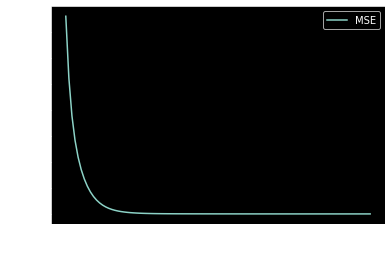

In [53]:
plt.plot(trainer.scores, label="MSE")
    
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend();

In [55]:
TINY_MODEL_PATH = 'saved_models/reversed_tiny_model.pt'

# torch.save(model.state_dict(), TINY_MODEL_PATH)

In [56]:
model.state_dict()

OrderedDict([('embedding.embedding.weight',
              tensor([[-0.1173,  0.5044,  0.4150,  0.4381, -0.2761,  0.4023, -0.1966, -0.1348,
                       -0.1766,  0.1199, -0.0733, -0.4171,  0.0078, -0.5455, -0.3019,  0.2608],
                      [ 0.0291,  0.1297, -0.1751, -0.4522,  0.0246,  0.4171,  0.0983, -0.0873,
                        0.0572,  0.5268, -0.2676,  0.1127,  0.3582, -0.1682, -0.3331,  0.4018],
                      [ 0.0342,  0.3555, -0.3076, -0.0418,  0.2928, -0.2844,  0.1130, -0.2431,
                       -0.4235,  0.0065, -0.4403, -0.3986,  0.5391,  0.2109, -0.2999,  0.4740],
                      [ 0.4131, -0.5290, -0.3378,  0.3230,  0.5614, -0.1519, -0.1016,  0.0042,
                        0.4265, -0.0466, -0.2532, -0.2034, -0.0625,  0.1636,  0.0695, -0.3454],
                      [-0.4462, -0.2096,  0.3797, -0.2139,  0.3417, -0.3523,  0.3332,  0.4481,
                       -0.2015,  0.3234,  0.1796,  0.4035,  0.0541,  0.3837, -0.1302, -0.4358],
 

### Other

In [28]:
embedding_weights = model.state_dict()['embedding.embedding.weight']
linear_weights = model.state_dict()['linear.fc.weight']
linear_bias = model.state_dict()['linear.bias']

model.state_dict()

linear_weights.shape

dataset.embedding_dimensions.sum()

117

In [84]:
# model = CustomLogisticRegression(binary_embedding_dimensions)

# model = CustomFactorizationMachine(binary_embedding_dimensions, embed_dim=16)

model = CustomDeepFactorizationMachineModel(binary_embedding_dimensions, 
                                            embed_dim=16, mlp_dims=(16, 16), dropout=0.2)

# model = CustomLinearRegression(input_dimensions=len(binary_embedding_dimensions),
#                                output_dimensions=1)

optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=LEARNING_RATE, 
                             weight_decay=WEIGHT_DECAY)

# optimizer = torch.optim.SGD(params=model.parameters(), lr=LEARNING_RATE)

In [1]:
# trainer.plot.plot(plot_target=False)

In [31]:
# trainer.plot.render_animation()

In [202]:
# trainer.plot.save_to_gif('images/test.gif')

In [ ]:
# with torch.no_grad():

#     predictions = split_trainer.model(torch.tensor(split_trainer.dataset.fields).int())

In [8]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-6
EPOCHS_COUNT = 1

# Binary

binary_dataset = BinaryOptionsDataset(OPTIONS_DATASET_PATH)

binary_splitter = Splitter(binary_dataset, batch_size=10)

binary_embedding_dimensions = binary_dataset.embedding_dimensions


# Models

binary_fm_model = CustomFactorizationMachine(binary_embedding_dimensions, embed_dim=16)

binary_deep_fm_model = CustomDeepFactorizationMachineModel(binary_embedding_dimensions,
                                                           embed_dim=16, mlp_dims=(16, 16), dropout=0.2)

binary_linear_model = CustomLinearRegression(input_dimensions=len(binary_embedding_dimensions),
                                             output_dimensions=1)


criterion = torch.nn.MSELoss()

metric = mean_squared_error


binary_fm_optimizer = torch.optim.Adam(params=binary_fm_model.parameters(),
                                       lr=LEARNING_RATE,
                                       weight_decay=WEIGHT_DECAY)

binary_deep_fm_optimizer = torch.optim.Adam(params=binary_deep_fm_model.parameters(),
                                            lr=LEARNING_RATE,
                                            weight_decay=WEIGHT_DECAY)

binary_linear_optimizer = torch.optim.Adam(params=binary_linear_model.parameters(),
                                           lr=LEARNING_RATE,
                                           weight_decay=WEIGHT_DECAY)

binary_fm_trainer = SplitTrainer(model=binary_fm_model,
                                 criterion=criterion,
                                 metric=metric,
                                 optimizer=binary_fm_optimizer,
                                 splitter=binary_splitter)

binary_deep_fm_trainer = SplitTrainer(model=binary_deep_fm_model,
                                      criterion=criterion,
                                      metric=metric,
                                      optimizer=binary_deep_fm_optimizer,
                                      splitter=binary_splitter)

binary_linear_trainer = SplitTrainer(model=binary_linear_model,
                                     criterion=criterion,
                                     metric=metric,
                                     optimizer=binary_linear_optimizer,
                                     splitter=binary_splitter)

dataset_length: 10201
train_length: 8160
valid_length: 1020
test_length: 1021


In [19]:
binary_fm_trainer.fit(epochs=EPOCHS_COUNT)

Epoch: 1/1: 100%|██████████████████████████████████████| 816/816 [00:03<00:00, 257.00 batches/s, loss=2.89e+6]


Validation mean_squared_error: 3353391.11, Duration: 3.45 seconds

Total - Test mean_squared_error: 3710378.33


In [20]:
binary_deep_fm_trainer.fit(epochs=EPOCHS_COUNT)

Epoch: 1/1: 100%|██████████████████████████████████████| 816/816 [00:04<00:00, 182.80 batches/s, loss=8.89e+5]


Validation mean_squared_error: 1806434.89, Duration: 4.76 seconds

Total - Test mean_squared_error: 1973852.98


In [21]:
binary_linear_trainer.fit(epochs=EPOCHS_COUNT)

Epoch: 1/1: 100%|██████████████████████████████████████| 816/816 [00:02<00:00, 283.63 batches/s, loss=2.31e+7]


Validation mean_squared_error: 22918524.62, Duration: 3.12 seconds

Total - Test mean_squared_error: 25722996.68


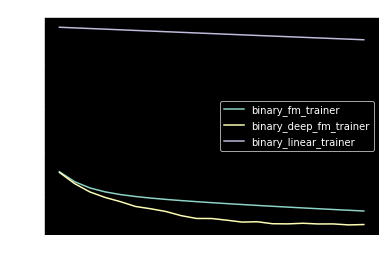

In [22]:
plt.plot(binary_fm_trainer.scores, label="binary_fm_trainer")
plt.plot(binary_deep_fm_trainer.scores, label="binary_deep_fm_trainer")
plt.plot(binary_linear_trainer.scores, label="binary_linear_trainer")
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend();

In [13]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-6
EPOCHS_COUNTHS_COUNT = 1

# Binary

dataset = BinaryOptionsDataset(OPTIONS_DATASET_PATH)

splitter = Splitter(binary_dataset, batch_size=10)

embedding_dimensions = dataset.embedding_dimensions

# Models

fm_model = CustomFactorizationMachine(embedding_dimensions, embed_dim=16)

deep_fm_model = CustomDeepFactorizationMachineModel(embedding_dimensions,
                                                    embed_dim=16, mlp_dims=(16, 16), dropout=0.2)

linear_model = CustomLinearRegression(input_dimensions=len(embedding_dimensions),
                                      output_dimensions=1)


criterion = torch.nn.MSELoss()

metric = mean_squared_error


fm_optimizer = torch.optim.Adam(params=fm_model.parameters(),
                                lr=LEARNING_RATE,
                                weight_decay=WEIGHT_DECAY)

deep_fm_optimizer = torch.optim.Adam(params=deep_fm_model.parameters(),
                                     lr=LEARNING_RATE,
                                     weight_decay=WEIGHT_DECAY)

linear_optimizer = torch.optim.Adam(params=linear_model.parameters(),
                                    lr=LEARNING_RATE,
                                    weight_decay=WEIGHT_DECAY)

fm_trainer = SplitTrainer(model=fm_model,
                          criterion=criterion,
                          metric=metric,
                          optimizer=fm_optimizer,
                          splitter=splitter)

deep_fm_trainer = SplitTrainer(model=deep_fm_model,
                               criterion=criterion,
                               metric=metric,
                               optimizer=deep_fm_optimizer,
                               splitter=splitter)

linear_trainer = SplitTrainer(model=linear_model,
                              criterion=criterion,
                              metric=metric,
                              optimizer=linear_optimizer,
                              splitter=splitter)

dataset_length: 10201
train_length: 8160
valid_length: 1020
test_length: 1021


In [23]:
fm_trainer.fit(epochs=EPOCHS_COUNT)

Epoch: 1/1: 100%|██████████████████████████████████████| 816/816 [00:03<00:00, 255.62 batches/s, loss=3.38e+6]


Validation mean_squared_error: 3176578.63, Duration: 3.49 seconds

Total - Test mean_squared_error: 3414384.87


In [24]:
deep_fm_trainer.fit(epochs=EPOCHS_COUNT)

Epoch: 1/1: 100%|██████████████████████████████████████| 816/816 [00:04<00:00, 178.25 batches/s, loss=2.85e+6]


Validation mean_squared_error: 1608093.32, Duration: 4.85 seconds

Total - Test mean_squared_error: 1675401.38


In [25]:
linear_trainer.fit(epochs=EPOCHS_COUNT)

Epoch: 1/1: 100%|██████████████████████████████████████| 816/816 [00:02<00:00, 288.57 batches/s, loss=3.44e+7]


Validation mean_squared_error: 23364332.11, Duration: 3.06 seconds

Total - Test mean_squared_error: 24982800.57


### Option Prices - 3D Plot

In [7]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

from IPython.display import HTML   


class OptionPricesPlot:

    def __init__(self,
                 elevation=10,
                 initial_azimuth=230):
        
        self.elevation = elevation
        self.initial_azimuth = initial_azimuth
        

    def plot(self, 
             plot_predictions=True, 
             plot_target=True):
                    
        self.calculate_grids() 

        figure = plt.figure(figsize=(5, 5))

        ax = figure.add_subplot(1, 1, 1, 
                                projection='3d', 
                                computed_zorder=False)

        if plot_predictions and 'predictions' in globals():

            predicted_surface = ax.plot_surface(self.initial_stock_prices_grid,
                                                self.volatilities_grid,
                                                self.predicted_option_prices_grid,
                                                # cmap='copper',
                                                color='indigo',
                                                linewidth=30,
                                                label='Predicted option prices',
                                                # alpha=1.0,
                                                zorder=500,
                                                antialiased=False)

        if plot_target:

            target_surface = ax.plot_surface(self.initial_stock_prices_grid,
                                             self.volatilities_grid,
                                             self.target_option_prices_grid,
                                             cmap='plasma',
                                             linewidth=30, 
                                             label='Target option prices',
                                             alpha=0.5,
                                             zorder=1000,
                                             antialiased=False)

        ax.view_init(elev=self.elevation, azim=self.initial_azimuth)
        
        ax.zaxis.set_rotate_label(False)

        ax.set_xlabel('Initial Stock Price')
        ax.set_ylabel('Volatility')
        ax.set_zlabel('Option Price', rotation=90)
        
        # figure.patch.set_facecolor('black')
        figure.patch.set_facecolor(ax.patch.get_facecolor())
        
        self.figure = figure
        self.ax = ax
        
 
    def animation_step(self, frame_index):

        azimuth = self.initial_azimuth + self.azimuth_step * frame_index

        self.ax.view_init(elev=self.elevation, azim=azimuth)

        
    def render_animation(self,
                         frames_count=12,
                         rotation_period=10):
        
        self.frames_count = frames_count
        self.rotation_period = rotation_period
        
        self.azimuth_step = 360 // frames_count
        self.frames_per_second = frames_count // rotation_period

        self.animation_model = animation.FuncAnimation(self.figure, 
                                                       self.animation_step, 
                                                       frames=self.frames_count, 
                                                       interval=50)

        rendered_animation = HTML(self.animation_model.to_jshtml(fps=self.frames_per_second))

        return rendered_animation


    def save_to_gif(self, path):

        self.animation_model.save(path, writer='pillow', fps=self.frames_per_second, dpi=100)
        

    def calculate_grids(self):
    
        # Data
        
        data = dataset.data

        initial_stock_prices = data.initial_stock_price.to_numpy()
        volatilities = data.volatility.to_numpy()
        option_prices= data.option_price.to_numpy()

        # Grids

        grid_side_size = np.sqrt(initial_stock_prices.shape[0]).astype(int)

        self.initial_stock_prices_grid = initial_stock_prices.reshape((grid_side_size, grid_side_size))
        self.volatilities_grid = volatilities.reshape((grid_side_size, grid_side_size))

        self.target_option_prices_grid = option_prices.reshape(-1, grid_side_size)
        
        if 'predictions' in globals():
        
            self.predicted_option_prices_grid = predictions.detach().reshape(-1, grid_side_size)